In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.lines import Line2D
import os
from pathlib import Path

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem
- No computation

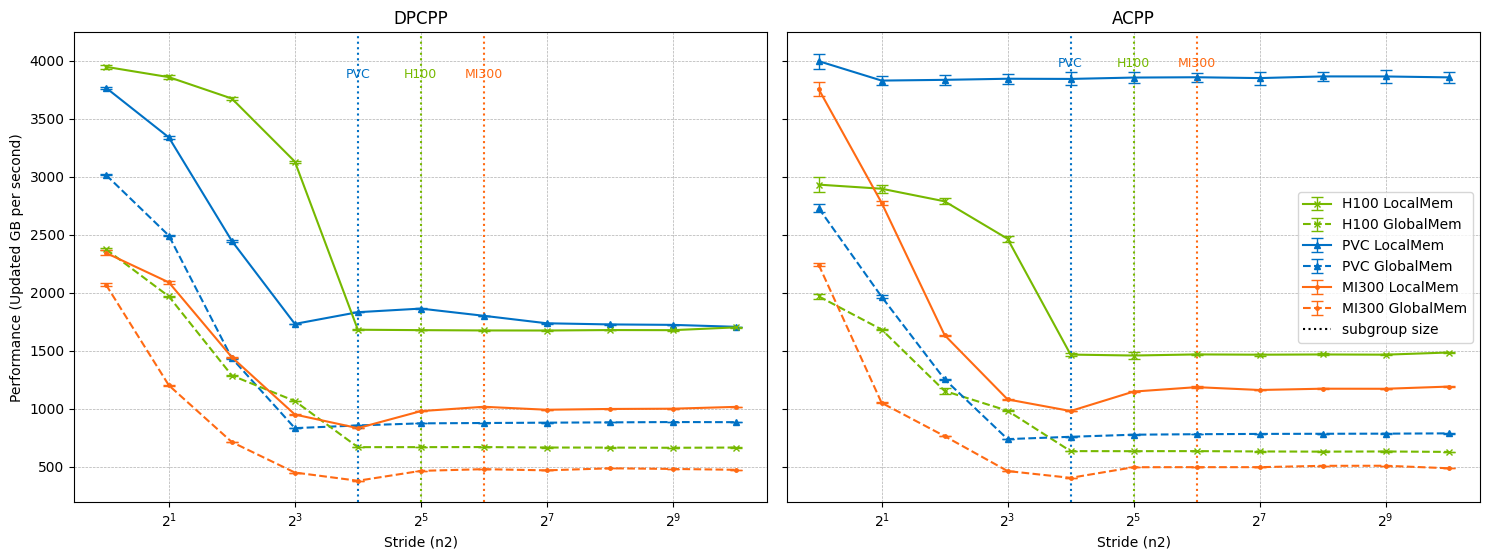

In [5]:


# Configuration
folder = "memory-spaces/"
compilers = ["dpcpp", "acpp"]
hardware_colors = {
    "h100": "#76B900",  # NVIDIA green
    "pvc": "#0071C5",   # Intel blue
    "mi300": "#FF6A13",
}

subgroup_sizes = {
    "h100": 32,   # NVIDIA warp
    "pvc": 16,    # Intel subgroup
    "mi300": 64
}

hardware_markers = {
    "h100": 'x',  # small cross
    "pvc": '^',   # triangle up
    # Add more markers here as needed
}

# Set up subplots: one per compiler
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, compiler in zip(axes, compilers):
    file_pattern = f"{folder}/{compiler}_50_reps_*.json"
    json_files = glob.glob(file_pattern)

    all_strides = set()  # Collect all strides for proper x-axis ticks

    for filepath in json_files:
        hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1].lower()
        color = hardware_colors.get(hardware, 'gray')

        with open(filepath) as f:
            data = json.load(f)

        df = pd.DataFrame(data["benchmarks"])
        all_strides.update(df["n2"].unique())  # Collect strides

        means = df[df["aggregate_name"] == "mean"].copy()
        stddevs = df[df["aggregate_name"] == "stddev"].copy()

        merge_keys = ["run_name", "per_family_instance_index"]
        merged = pd.merge(
            means,
            stddevs[merge_keys + ["bytes_per_second"]],
            on=merge_keys,
            suffixes=("", "_stddev")
        )

        merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
        merged["stride"] = merged["n2"]
        merged["GBps"] = merged["bytes_per_second"] / 1e9
        merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

        for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
            subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
            label = f"{hardware.upper()} {mem_type}"

            ax.errorbar(
                subset["stride"],
                subset["GBps"],
                yerr=subset["GBps_stddev"],
                capsize=4,
                elinewidth=1,
                label=label,
                linestyle=style,
                marker=hardware_markers.get(hardware, '.'),
                markersize=5,
                color=color
            )

    # Set log2 scale and base-10 stride labels
    all_strides = sorted(all_strides)
    ax.set_xscale("log", base=2)
    # ax.set_xticklabels([str(np.log2(x)) for x in all_strides])
    # ax.set_xticks(all_strides)
    ax.set_xlabel("Stride (n2)")
    ax.set_title(f"{compiler.upper()}")

    # Add subgroup size marker lines
    for hw, size in subgroup_sizes.items():
        if hw in hardware_colors:
            ax.axvline(x=size, color=hardware_colors[hw], linestyle=":", linewidth=1.5)
            ax.text(
                size, ax.get_ylim()[1] * 0.95,
                f"{hw.upper()}",
                color=hardware_colors[hw],
                ha="center", va="top", fontsize=9
            )

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend line for subgroup size marker
subgroup_legend = Line2D(
    [0], [0],
    color='black',
    linestyle=':',
    linewidth=1.5,
    label='subgroup size'
)
# Single legend on second subplot
axes[1].legend(handles=[*axes[1].get_legend_handles_labels()[0], subgroup_legend], loc="best")
# Shared Y label
axes[0].set_ylabel("Performance (Updated GB per second)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("memory-spaces.pdf")
plt.show()


# Operations order

- Copy/solve vs solve/copy
- 2 applications with 2 sizes each (total elements 2**28):
    - conv1d
        - k=1, l=8192, c=1, n=32768
        - k=3, l=2048, c=4, n=32768
    - lag advection
        - n0=32768, n1=8192, n2=1
        - n0=1024, n1=8192, n2=32


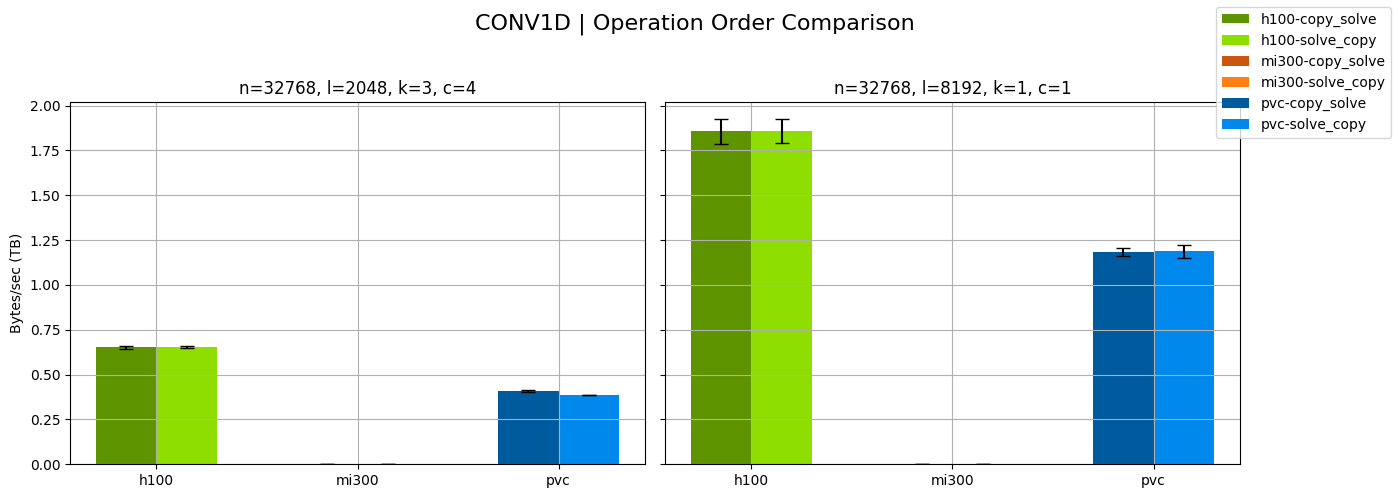

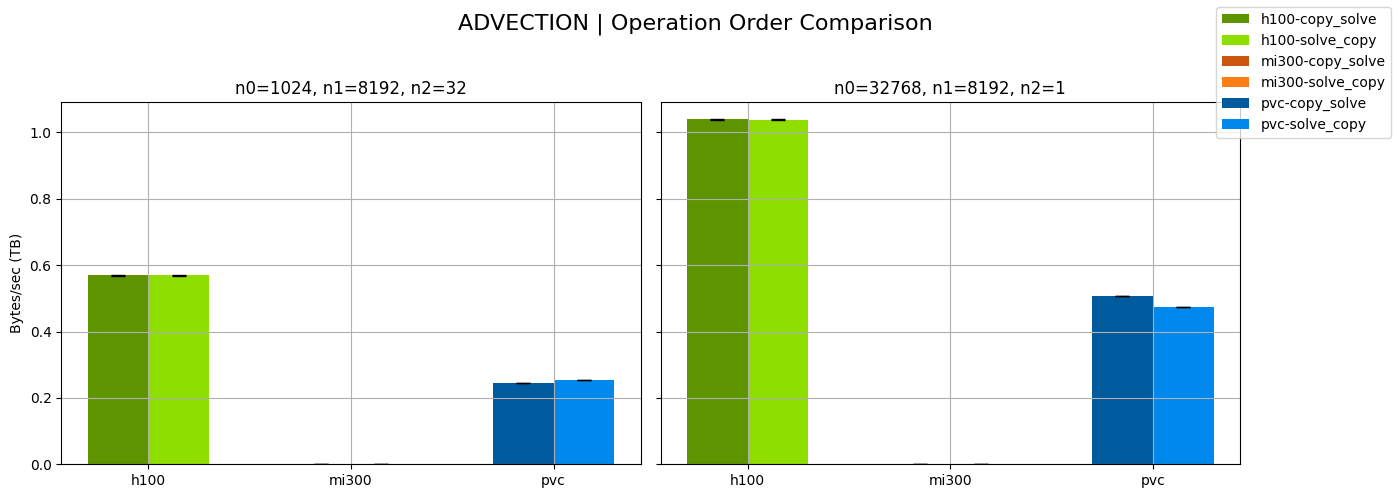

In [2]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Constants
base_dir = Path("/home/ac.amillan/source/parallel-advection/jlse/out/operation_order")
orders = ["copy_solve", "solve_copy"]
hardware_list = ['h100', 'mi300', 'pvc']
hardware_colors = {'h100': '#76B900', 'mi300': '#FF6A13', 'pvc': '#0071C5'}
order_factors = {'copy_solve': 0.8, 'solve_copy': 1.2}

def adjust_color_brightness(hex_color, factor=1.0):
    rgb = mcolors.to_rgb(hex_color)
    adjusted = [min(1, max(0, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted)

# Load and parse benchmark data
records = []
for order in orders:
    order_path = base_dir / order
    for file in order_path.glob("*.json"):
        parts = file.stem.split("_")
        if len(parts) != 3:
            continue
        app, hw, impl = parts
        if impl not in ['dpcpp', 'acpp'] or hw not in hardware_list:
            continue
        with open(file) as f:
            data = json.load(f)
            benchmarks = data["benchmarks"]
            grouped = defaultdict(dict)
            for b in benchmarks:
                if "aggregate_name" in b:
                    run_id = b.get("run_name", b.get("name"))
                    grouped[run_id][b["aggregate_name"]] = b
            for run, agg in grouped.items():
                if "mean" in agg and "stddev" in agg:
                    b_mean = agg["mean"]
                    b_std = agg["stddev"]
                    if app == "conv1d":
                        n = int(float(b_mean.get("batch_size", 0)))
                        l = int(float(b_mean.get("input_length", 0)))
                        k = int(float(b_mean.get("kernel_size", 0)))
                        c = int(float(b_mean.get("channels", 0)))
                        size_str = f"n={n}, l={l}, k={k}, c={c}"
                    else:
                        n0 = int(float(b_mean.get("n0", 0)))
                        n1 = int(float(b_mean.get("n1", 0)))
                        n2 = int(float(b_mean.get("n2", 0)))
                        size_str = f"n0={n0}, n1={n1}, n2={n2}"
                    records.append({
                        "app": app,
                        "size": size_str,
                        "hardware": hw,
                        "impl": impl,
                        "order": order,
                        "mean_bps": b_mean["bytes_per_second"],
                        "std_bps": b_std["bytes_per_second"]
                    })

# Create DataFrame with schema
columns = ["app", "size", "hardware", "impl", "order", "mean_bps", "std_bps"]
df = pd.DataFrame(records, columns=columns)

if df.empty:
    print("No benchmark data found.")
else:
    for app in df["app"].unique():
        app_df = df[df["app"] == app]
        sizes = sorted(app_df["size"].unique())
        fig, axes = plt.subplots(1, len(sizes), figsize=(7 * len(sizes), 5), sharey=True)
        if len(sizes) == 1:
            axes = [axes]
        for ax, size in zip(axes, sizes):
            size_df = app_df[app_df["size"] == size]
            for i, hw in enumerate(hardware_list):
                for j, order in enumerate(orders):
                    row = size_df.query(f"hardware == '{hw}' and order == '{order}'")
                    if not row.empty:
                        mean_val = row['mean_bps'].values[0] / 1e12
                        std_val = row['std_bps'].values[0] / 1e12
                    else:
                        mean_val = 0
                        std_val = 0
                    color = adjust_color_brightness(hardware_colors[hw], order_factors[order])
                    ax.bar(i + j * 0.3 - 0.15, mean_val, yerr=std_val, width=0.3,
                           color=color, capsize=5, label=f"{hw}-{order}")
            ax.set_title(size)
            ax.set_xticks(range(len(hardware_list)))
            ax.set_xticklabels(hardware_list)
            ax.grid()

        axes[0].set_ylabel("Bytes/sec (TB)")
        fig.suptitle(f"{app.upper()} | Operation Order Comparison", fontsize=16)
        handles, labels = axes[-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        plt.savefig(f"operations-order-{app}.pdf")
        plt.show()
